In [231]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import defaultdict
from sklearn.model_selection import KFold
import numpy as np
from sklearn.model_selection import train_test_split
from math import exp
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
data_path = 'C:/Users/IMOE001/Text Classification/training'

# Loading  the data 

In [3]:
labeled_dataset = []

for class_name in os.listdir(data_path):
    class_folder = os.path.join(data_path, class_name)
    
    if os.path.isdir(class_folder):
        for filename in os.listdir(class_folder):
            with open(os.path.join(class_folder, filename), 'r', encoding='utf-8') as file:
                document_content = file.read()
            
            labeled_dataset.append((document_content, class_name))

In [4]:
labeled_dataset

[("\n\nCOMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SALE\n\n     COMMACK, N.Y., Feb 26 - Computer Terminal Systems Inc said\nit has completed the sale of 200,000 shares of its common\nstock, and warrants to acquire an additional one mln shares, to\n<Sedio N.V.> of Lugano, Switzerland for 50,000 dlrs.\n    The company said the warrants are exercisable for five\nyears at a purchase price of .125 dlrs per share.\n    Computer Terminal said Sedio also has the right to buy\nadditional shares and increase its total holdings up to 40 pct\nof the Computer Terminal's outstanding common stock under\ncertain circumstances involving change of control at the\ncompany.\n    The company said if the conditions occur the warrants would\nbe exercisable at a price equal to 75 pct of its common stock's\nmarket price at the time, not to exceed 1.50 dlrs per share.\n    Computer Terminal also said it sold the technolgy rights to\nits Dot Matrix impact technology, including any future\nimprovements, to <Woodco

In [5]:
# Convert the list to dictionary 
labeled_dict = {
    'document_content': [item[0] for item in labeled_dataset],
    'class_label': [item[1] for item in labeled_dataset]
}

In [6]:
labeled_dict

{'document_content': ["\n\nCOMPUTER TERMINAL SYSTEMS <CPML> COMPLETES SALE\n\n     COMMACK, N.Y., Feb 26 - Computer Terminal Systems Inc said\nit has completed the sale of 200,000 shares of its common\nstock, and warrants to acquire an additional one mln shares, to\n<Sedio N.V.> of Lugano, Switzerland for 50,000 dlrs.\n    The company said the warrants are exercisable for five\nyears at a purchase price of .125 dlrs per share.\n    Computer Terminal said Sedio also has the right to buy\nadditional shares and increase its total holdings up to 40 pct\nof the Computer Terminal's outstanding common stock under\ncertain circumstances involving change of control at the\ncompany.\n    The company said if the conditions occur the warrants would\nbe exercisable at a price equal to 75 pct of its common stock's\nmarket price at the time, not to exceed 1.50 dlrs per share.\n    Computer Terminal also said it sold the technolgy rights to\nits Dot Matrix impact technology, including any future\nimpr

In [7]:
df = pd.DataFrame(labeled_dict)

In [8]:
df

document_content class_label
0      \n\nCOMPUTER TERMINAL SYSTEMS <CPML> COMPLETES...         acq
1      \n\nOHIO MATTRESS <OMT> MAY HAVE LOWER 1ST QTR...         acq
2      \n\nMCLEAN'S <MII> U.S. LINES SETS ASSET TRANS...         acq
3      \n\nCHEMLAWN <CHEM> RISES ON HOPES FOR HIGHER ...         acq
4      \n\n<COFAB INC> BUYS GULFEX FOR UNDISCLOSED AM...         acq
...                                                  ...         ...
11408  \n\nPEGASUS GOLD <PGULF> STARTS MILLING IN MON...        zinc
11409  \n\nWORLD ZINC STOCKS FALL 7,700 TONNES IN FEB...        zinc
11410  \n\nLME DETAILS MARCH 1987 TURNOVER\n\n    LON...        zinc
11411  \n\nBALL <BLL> TO SUPPLY PENNY BLANKS TO MINTS...        zinc
11412  \n\nWESTMIN TO RAISE MYRA FALLS CAPACITY BY 33...        zinc

[11413 rows x 2 columns]

In [10]:
df.to_csv('C:\\Users\\IMOE001\\Text Classification\\df.csv', index=False)

In [11]:
del labeled_dict 

In [12]:
del labeled_dataset

In [13]:
df['document_content'].nunique()

9459

# There is a 9459 unique documents content

In [14]:
df['class_label'].nunique()

91

# There is a 91 Classes 

In [15]:
df.isna().sum()

document_content    0
class_label         0
dtype: int64

In [16]:
# no missing value in data set:)

In [17]:
df['class_label'].unique()

array(['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa',
       'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn',
       'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk',
       'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut',
       'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt',
       'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead',
       'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx',
       'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr',
       'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel',
       'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil',
       'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship',
       'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean',
       'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed',
       'tea', 'tin', 'trade', 'unknown', 'veg-oil', 'wheat', 'wpi

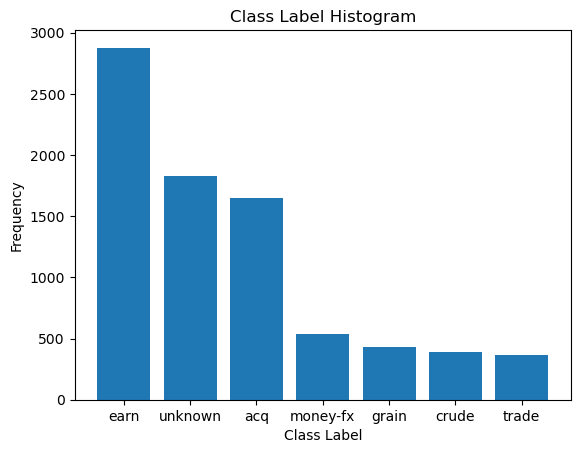

In [18]:
class_counts = df['class_label'].value_counts()[0:7]

plt.bar(class_counts.index, class_counts.values)
plt.title('Class Label Histogram')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.show()

# The most Frequent class is earn class

# Preprocessing Phase

In [19]:
#Remove Special Charcter + punctuation marks Like \ / < > \n ' " . ? ! - ( ) + [ ] _ , ; 
def remove_special_characters(column):
    cleaned_texts = []
    for text in column:
        pattern =  r'[-\/\n\'".,?!(){}\[\]_+;<>,^#!?&\']'

        cleaned_text = re.sub(pattern, '', text)

        cleaned_texts.append(cleaned_text)

    return cleaned_texts
cleaned_column = remove_special_characters(df['document_content'])
print(cleaned_column)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
df['document_content'] = cleaned_column

In [21]:
del cleaned_column

In [22]:
df

document_content class_label
0      COMPUTER TERMINAL SYSTEMS CPML COMPLETES SALE ...         acq
1      OHIO MATTRESS OMT MAY HAVE LOWER 1ST QTR NET  ...         acq
2      MCLEANS MII US LINES SETS ASSET TRANSFER    CR...         acq
3      CHEMLAWN CHEM RISES ON HOPES FOR HIGHER BIDSAU...         acq
4      COFAB INC BUYS GULFEX FOR UNDISCLOSED AMOUNT  ...         acq
...                                                  ...         ...
11408  PEGASUS GOLD PGULF STARTS MILLING IN MONTANA  ...        zinc
11409  WORLD ZINC STOCKS FALL 7700 TONNES IN FEBRUARY...        zinc
11410  LME DETAILS MARCH 1987 TURNOVER    LONDON Apri...        zinc
11411  BALL BLL TO SUPPLY PENNY BLANKS TO MINTS    MU...        zinc
11412  WESTMIN TO RAISE MYRA FALLS CAPACITY BY 33 PCT...        zinc

[11413 rows x 2 columns]

# Toknization

In [23]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\IMOE001\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# NLTK's Tokenizer

In [24]:
def tokenize(column):
    toknized_column = []
    for text in column : 
        tokens = nltk.word_tokenize(text)
        toknized_column.append(tokens)
    return toknized_column

In [25]:
toknized_column = tokenize(df["document_content"])

In [26]:
df["document_content"] = toknized_column 

In [27]:
del toknized_column

# Case Floding

In [28]:
def lowercase_folding(column):
    lowecase_column = [ ]
    for tokens in column : 
        lowercase_tokens = []
        for token in tokens : 
            lowercase_tokens.append(token.lower())
        lowecase_column.append(lowercase_tokens)   
    return lowecase_column

In [29]:
lowercase_tokens = lowercase_folding(df["document_content"])
print(lowercase_tokens)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [30]:
lowercase_tokens

[['computer',
  'terminal',
  'systems',
  'cpml',
  'completes',
  'sale',
  'commack',
  'ny',
  'feb',
  '26',
  'computer',
  'terminal',
  'systems',
  'inc',
  'saidit',
  'has',
  'completed',
  'the',
  'sale',
  'of',
  '200000',
  'shares',
  'of',
  'its',
  'commonstock',
  'and',
  'warrants',
  'to',
  'acquire',
  'an',
  'additional',
  'one',
  'mln',
  'shares',
  'tosedio',
  'nv',
  'of',
  'lugano',
  'switzerland',
  'for',
  '50000',
  'dlrs',
  'the',
  'company',
  'said',
  'the',
  'warrants',
  'are',
  'exercisable',
  'for',
  'fiveyears',
  'at',
  'a',
  'purchase',
  'price',
  'of',
  '125',
  'dlrs',
  'per',
  'share',
  'computer',
  'terminal',
  'said',
  'sedio',
  'also',
  'has',
  'the',
  'right',
  'to',
  'buyadditional',
  'shares',
  'and',
  'increase',
  'its',
  'total',
  'holdings',
  'up',
  'to',
  '40',
  'pctof',
  'the',
  'computer',
  'terminals',
  'outstanding',
  'common',
  'stock',
  'undercertain',
  'circumstances',
  '

In [31]:
df["document_content"] = lowercase_tokens 

In [32]:
del lowercase_tokens

In [33]:
# Removeing Stop Words 

In [38]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\IMOE001\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
 stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [40]:
def remove_stop_words(column):
    filtered_column = []
    stop_words = set(stopwords.words('english'))
    for tokens in column:
        filtered_tokens = [token for token in tokens if token not in stop_words]
        filtered_column.append(filtered_tokens)
    return filtered_column


In [41]:
df["document_content"] = remove_stop_words(df["document_content"])

# Stemming

In [42]:
porter = PorterStemmer()

In [43]:
def stem_tokens(tokens):
    stemmed_tokens = [porter.stem(token) for token in tokens]
    return stemmed_tokens

In [44]:
def stem_column(column):
    stemmed_column = [stem_tokens(tokens) for tokens in column]
    return stemmed_column

In [45]:
stemmed_column = stem_column(df["document_content"])

In [46]:
stemmed_column

[['comput',
  'termin',
  'system',
  'cpml',
  'complet',
  'sale',
  'commack',
  'ny',
  'feb',
  '26',
  'comput',
  'termin',
  'system',
  'inc',
  'saidit',
  'complet',
  'sale',
  '200000',
  'share',
  'commonstock',
  'warrant',
  'acquir',
  'addit',
  'one',
  'mln',
  'share',
  'tosedio',
  'nv',
  'lugano',
  'switzerland',
  '50000',
  'dlr',
  'compani',
  'said',
  'warrant',
  'exercis',
  'fiveyear',
  'purchas',
  'price',
  '125',
  'dlr',
  'per',
  'share',
  'comput',
  'termin',
  'said',
  'sedio',
  'also',
  'right',
  'buyaddit',
  'share',
  'increas',
  'total',
  'hold',
  '40',
  'pctof',
  'comput',
  'termin',
  'outstand',
  'common',
  'stock',
  'undercertain',
  'circumst',
  'involv',
  'chang',
  'control',
  'thecompani',
  'compani',
  'said',
  'condit',
  'occur',
  'warrant',
  'wouldb',
  'exercis',
  'price',
  'equal',
  '75',
  'pct',
  'common',
  'stocksmarket',
  'price',
  'time',
  'exceed',
  '150',
  'dlr',
  'per',
  'share',


In [47]:
df["document_content"] = stemmed_column

In [48]:
del stemmed_column

In [49]:
#after we done of testing try to remove numbers and use digit .

In [50]:
def Vocabulary_set_extraction(document_content):
    flattened_content = [word for sublist in document_content for word in sublist]
    
    word_counts = {}
    for word in flattened_content:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
    
    sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1] ,  reverse=True))
    
    vocabulary = {word: count for word, count in sorted_word_counts.items() if count > 5}

    return vocabulary

In [52]:
def compute_word_counts_by_class(documents, class_labels, vocabulary):
    word_counts_by_class = defaultdict(lambda: defaultdict(int))
    for word in vocabulary:
        for document, class_label in zip(documents, class_labels):
            if word in document:
                word_counts_by_class[class_label][word] += 1
    return word_counts_by_class

In [53]:
unique_words = Vocabulary_set_extraction(df["document_content"])

In [54]:
#the size of Vocabulary = 86111 =>try to reduce it . 

# Reducing the size of  Vocabulary from 86,111 to 12241 by take only the words with counts greater than 10

In [55]:
len(unique_words)

12241

In [56]:
word_counts_by_class = compute_word_counts_by_class(df['document_content'],df['class_label'],unique_words)

In [57]:
the_vocabulary = pd.DataFrame(word_counts_by_class)

In [71]:
the_vocabulary.head(40)

acq  alum  barley   bop  carcass  cocoa  coconut  coconut-oil  \
said     1453.0  30.0    28.0  55.0     46.0   48.0      2.0          4.0   
mln       703.0  10.0    14.0  41.0     12.0   10.0      2.0          2.0   
dlr       852.0   4.0     4.0  45.0      9.0   10.0      2.0          2.0   
pct       642.0   8.0     5.0  28.0     15.0   12.0      NaN          1.0   
march    1291.0  30.0    27.0  58.0     42.0   44.0      3.0          3.0   
year      227.0  14.0     6.0  45.0     21.0   10.0      1.0          2.0   
bank      206.0   1.0     NaN  22.0      NaN    3.0      NaN          NaN   
us        195.0   4.0    11.0  20.0     19.0    7.0      1.0          2.0   
ct         32.0   1.0     NaN   NaN      NaN    NaN      NaN          NaN   
billion   121.0   1.0     1.0  66.0      2.0    2.0      NaN          NaN   
would     342.0  12.0     3.0  20.0     17.0   22.0      1.0          2.0   
net        60.0   NaN     NaN  10.0      NaN    1.0      NaN          NaN   
price     240.0  12.0     5.0  14.0      8.0   25.0      NaN          2.0   
compani   818.0  12.0     1.0   2.0      6.0    1.0      NaN          NaN   
market    180.0   5.0     7.0  13.0     15.0   16.0      1.0          2.0   
new       462.0  11.0     2.0  11.0      8.0   23.0      2.0          1.0   
loss       49.0   3.0     NaN   4.0      1.0    3.0      NaN          NaN   
share     712.0   NaN     NaN   1.0      2.0    3.0      NaN          1.0   
trade     106.0   5.0     6.0  52.0     14.0   17.0      1.0          2.0   
tonn        3.0  17.0    29.0   NaN     16.0   21.0      2.0          2.0   
rate       24.0   5.0     2.0  16.0      2.0    2.0      NaN          1.0   
april     297.0   6.0     8.0   3.0     15.0   10.0      1.0          1.0   
1986      176.0   5.0     5.0  45.0      9.0    8.0      NaN          NaN   
inc       805.0   1.0     1.0   2.0      8.0    1.0      NaN          NaN   
last      200.0   7.0     3.0  31.0     13.0   18.0      1.0          2.0   
oil        72.0   1.0     1.0  13.0      3.0    2.0      1.0          4.0   
shr         3.0   NaN     NaN   NaN      NaN    NaN      NaN          NaN   
export      6.0   3.0    21.0  35.0     12.0   14.0      3.0          1.0   
corp      694.0   5.0     1.0   2.0      7.0    NaN      NaN          NaN   
also      341.0   5.0     3.0   6.0     15.0   14.0      2.0          1.0   
sale      330.0   4.0     4.0   6.0      1.0    2.0      1.0          1.0   
one       244.0   6.0     4.0  12.0      3.0   14.0      NaN          2.0   
offer     380.0   2.0     2.0   2.0      9.0   12.0      NaN          NaN   
profit     69.0   3.0     NaN   2.0      2.0    1.0      NaN          NaN   
stock     425.0   3.0     4.0   5.0      4.0   33.0      NaN          1.0   
product   129.0  10.0     2.0  10.0     18.0    4.0      2.0          1.0   
expect    217.0   6.0     3.0  23.0      8.0   13.0      NaN          1.0   
oper      204.0   8.0     3.0   1.0     10.0   11.0      NaN          1.0   
report    115.0   4.0     4.0  11.0      8.0    6.0      1.0          1.0   
two       201.0   9.0     3.0  10.0      5.0   11.0      NaN          NaN   

         coffee  copper  ...  unknown  veg-oil  wheat   wpi   yen  zinc  \
said      100.0    43.0  ...   1579.0     76.0  171.0  16.0  34.0  16.0   
mln        36.0    12.0  ...   1061.0     26.0   81.0   1.0   4.0   7.0   
dlr        34.0    11.0  ...   1136.0     26.0   56.0   2.0  19.0   5.0   
pct        30.0    15.0  ...    856.0     14.0   48.0  18.0  15.0   7.0   
march      87.0    28.0  ...   1422.0     72.0  167.0  17.0  32.0  19.0   
year       47.0    13.0  ...    492.0     24.0   69.0  12.0  15.0   4.0   
bank       13.0     NaN  ...    682.0      4.0    1.0   2.0  22.0   NaN   
us         23.0    11.0  ...    264.0     36.0  119.0   5.0  25.0   6.0   
ct          NaN    10.0  ...     18.0      NaN    NaN   NaN   NaN   1.0   
billion    16.0     3.0  ...    497.0      4.0   12.0   1.0   6.0   NaN   
would      47.0    12.0  ... 

In [63]:
del word_counts_by_class

In [64]:
#Handle the missing + unKnown word + compute the conidtional probability for each word  

In [65]:
the_vocabulary.isna().sum().sum()

986670

In [66]:
num_rows, num_columns = the_vocabulary.shape

In [67]:
total_count_for_vocabulary = num_rows * num_columns

In [68]:
Sparsity = ((the_vocabulary.isna().sum().sum()) / total_count_for_vocabulary)*100

In [69]:
Sparsity

88.57550422782022

In [72]:
# handle the missing 

In [74]:
the_vocabulary = the_vocabulary.fillna(0)

In [75]:
the_vocabulary

acq  alum  barley   bop  carcass  cocoa  coconut  \
said             1453.0  30.0    28.0  55.0     46.0   48.0      2.0   
mln               703.0  10.0    14.0  41.0     12.0   10.0      2.0   
dlr               852.0   4.0     4.0  45.0      9.0   10.0      2.0   
pct               642.0   8.0     5.0  28.0     15.0   12.0      0.0   
march            1291.0  30.0    27.0  58.0     42.0   44.0      3.0   
...                 ...   ...     ...   ...      ...    ...      ...   
sayad               0.0   0.0     0.0   0.0      0.0    0.0      0.0   
dlreurocommerci     0.0   0.0     0.0   0.0      0.0    0.0      0.0   
fernandez           0.0   0.0     0.0   0.0      0.0    0.0      0.0   
indentur            0.0   0.0     0.0   0.0      0.0    0.0      0.0   
nephew              0.0   0.0     0.0   0.0      0.0    0.0      0.0   

                 coconut-oil  coffee  copper  ...  unknown  veg-oil  wheat  \
said                     4.0   100.0    43.0  ...   1579.0     76.0  171.0   
mln                      2.0    36.0    12.0  ...   1061.0     26.0   81.0   
dlr                      2.0    34.0    11.0  ...   1136.0     26.0   56.0   
pct                      1.0    30.0    15.0  ...    856.0     14.0   48.0   
march                    3.0    87.0    28.0  ...   1422.0     72.0  167.0   
...                      ...     ...     ...  ...      ...      ...    ...   
sayad                    0.0     0.0     0.0  ...      3.0      0.0    0.0   
dlreurocommerci          0.0     0.0     0.0  ...      6.0      0.0    0.0   
fernandez                0.0     0.0     0.0  ...      4.0      0.0    0.0   
indentur                 0.0     0.0     0.0  ...      5.0      0.0    0.0   
nephew                   0.0     0.0     0.0  ...      2.0      0.0    0.0   

                  wpi   yen  zinc  sun-meal  castor-oil  lin-oil  rye  
said             16.0  34.0  16.0       0.0         0.0      0.0  0.0  
mln               1.0   4.0   7.0       0.0         0.0      0.0  0.0  
dlr               2.0  19.0   5.0       1.0         0.0      0.0  0.0  
pct              18.0  15.0   7.0       0.0         0.0      0.0  0.0  
march            17.0  32.0  19.0       0.0         1.0      1.0  0.0  
...               ...   ...   ...       ...         ...      ...  ...  
sayad             0.0   0.0   0.0       0.0         0.0      0.0  0.0  
dlreurocommerci   0.0   0.0   0.0       0.0         0.0      0.0  0.0  
fernandez         0.0   0.0   0.0       0.0         0.0      0.0  0.0  
indentur          0.0   0.0   0.0       0.0         0.0      0.0  0.0  
nephew            0.0   0.0   0.0       0.0         0.0      0.0  0.0  

[12241 rows x 91 columns]

In [76]:
transposed_the_vocabulary = the_vocabulary.transpose()

In [78]:
most_frequent_words = {}
for class_name, row in transposed_the_vocabulary.iterrows():
    most_frequent_word = row.idxmax()
    most_frequent_words[class_name] = most_frequent_word
for class_name, word in most_frequent_words.items():
    print(f"Most frequent word in class '{class_name}': {word}")

Most frequent word in class 'acq': said
Most frequent word in class 'alum': said
Most frequent word in class 'barley': barley
Most frequent word in class 'bop': billion
Most frequent word in class 'carcass': said
Most frequent word in class 'cocoa': cocoa
Most frequent word in class 'coconut': philippin
Most frequent word in class 'coconut-oil': said
Most frequent word in class 'coffee': coffe
Most frequent word in class 'copper': copper
Most frequent word in class 'copra-cake': said
Most frequent word in class 'corn': said
Most frequent word in class 'cotton': cotton
Most frequent word in class 'cotton-oil': said
Most frequent word in class 'cpi': pct
Most frequent word in class 'cpu': pct
Most frequent word in class 'crude': oil
Most frequent word in class 'dfl': said
Most frequent word in class 'dlr': dollar
Most frequent word in class 'dmk': bank
Most frequent word in class 'earn': march
Most frequent word in class 'fuel': said
Most frequent word in class 'gas': said
Most frequent 

# Handle out-of-vocabulary words 

In [81]:
the_vocabulary.loc['<UNK>'] = 1

In [82]:
the_vocabulary

acq  alum  barley   bop  carcass  cocoa  coconut  \
said             1453.0  30.0    28.0  55.0     46.0   48.0      2.0   
mln               703.0  10.0    14.0  41.0     12.0   10.0      2.0   
dlr               852.0   4.0     4.0  45.0      9.0   10.0      2.0   
pct               642.0   8.0     5.0  28.0     15.0   12.0      0.0   
march            1291.0  30.0    27.0  58.0     42.0   44.0      3.0   
...                 ...   ...     ...   ...      ...    ...      ...   
dlreurocommerci     0.0   0.0     0.0   0.0      0.0    0.0      0.0   
fernandez           0.0   0.0     0.0   0.0      0.0    0.0      0.0   
indentur            0.0   0.0     0.0   0.0      0.0    0.0      0.0   
nephew              0.0   0.0     0.0   0.0      0.0    0.0      0.0   
<UNK>               1.0   1.0     1.0   1.0      1.0    1.0      1.0   

                 coconut-oil  coffee  copper  ...  unknown  veg-oil  wheat  \
said                     4.0   100.0    43.0  ...   1579.0     76.0  171.0   
mln                      2.0    36.0    12.0  ...   1061.0     26.0   81.0   
dlr                      2.0    34.0    11.0  ...   1136.0     26.0   56.0   
pct                      1.0    30.0    15.0  ...    856.0     14.0   48.0   
march                    3.0    87.0    28.0  ...   1422.0     72.0  167.0   
...                      ...     ...     ...  ...      ...      ...    ...   
dlreurocommerci          0.0     0.0     0.0  ...      6.0      0.0    0.0   
fernandez                0.0     0.0     0.0  ...      4.0      0.0    0.0   
indentur                 0.0     0.0     0.0  ...      5.0      0.0    0.0   
nephew                   0.0     0.0     0.0  ...      2.0      0.0    0.0   
<UNK>                    1.0     1.0     1.0  ...      1.0      1.0    1.0   

                  wpi   yen  zinc  sun-meal  castor-oil  lin-oil  rye  
said             16.0  34.0  16.0       0.0         0.0      0.0  0.0  
mln               1.0   4.0   7.0       0.0         0.0      0.0  0.0  
dlr               2.0  19.0   5.0       1.0         0.0      0.0  0.0  
pct              18.0  15.0   7.0       0.0         0.0      0.0  0.0  
march            17.0  32.0  19.0       0.0         1.0      1.0  0.0  
...               ...   ...   ...       ...         ...      ...  ...  
dlreurocommerci   0.0   0.0   0.0       0.0         0.0      0.0  0.0  
fernandez         0.0   0.0   0.0       0.0         0.0      0.0  0.0  
indentur          0.0   0.0   0.0       0.0         0.0      0.0  0.0  
nephew            0.0   0.0   0.0       0.0         0.0      0.0  0.0  
<UNK>             1.0   1.0   1.0       1.0         1.0      1.0  1.0  

[12242 rows x 91 columns]

# Learning Modle Parmetars 

In [ ]:
#compute the conditional probability for each words

In [100]:
def compute_conditional_probabilities(df):
    class_counts = df.sum(axis=0)
    
    # Add 1 to both numerator and denominator for Laplace smoothing
    conditional_probabilities = (df + 1) / (class_counts + len(df.index))
    
    return conditional_probabilities


In [101]:
conditional_probabilities_df = compute_conditional_probabilities(the_vocabulary)

In [102]:
conditional_probabilities_df

acq      alum    barley       bop   carcass     cocoa  \
said             0.015801  0.002172  0.002053  0.003006  0.002954  0.002866   
mln              0.007651  0.000771  0.001062  0.002254  0.000817  0.000643   
dlr              0.009270  0.000350  0.000354  0.002469  0.000629  0.000643   
pct              0.006988  0.000631  0.000425  0.001557  0.001006  0.000760   
march            0.014040  0.002172  0.001982  0.003167  0.002703  0.002632   
...                   ...       ...       ...       ...       ...       ...   
dlreurocommerci  0.000011  0.000070  0.000071  0.000054  0.000063  0.000058   
fernandez        0.000011  0.000070  0.000071  0.000054  0.000063  0.000058   
indentur         0.000011  0.000070  0.000071  0.000054  0.000063  0.000058   
nephew           0.000011  0.000070  0.000071  0.000054  0.000063  0.000058   
<UNK>            0.000022  0.000140  0.000142  0.000107  0.000126  0.000117   

                  coconut  coconut-oil    coffee    copper  ...   unknown  \
said             0.000242     0.000394  0.004557  0.002960  ...  0.013559   
mln              0.000242     0.000236  0.001669  0.000874  ...  0.009114   
dlr              0.000242     0.000236  0.001579  0.000807  ...  0.009758   
pct              0.000081     0.000158  0.001399  0.001076  ...  0.007355   
march            0.000323     0.000315  0.003971  0.001951  ...  0.012212   
...                   ...          ...       ...       ...  ...       ...   
dlreurocommerci  0.000081     0.000079  0.000045  0.000067  ...  0.000060   
fernandez        0.000081     0.000079  0.000045  0.000067  ...  0.000043   
indentur         0.000081     0.000079  0.000045  0.000067  ...  0.000051   
nephew           0.000081     0.000079  0.000045  0.000067  ...  0.000026   
<UNK>            0.000161     0.000158  0.000090  0.000135  ...  0.000017   

                  veg-oil     wheat       wpi       yen      zinc  sun-meal  \
said             0.004255  0.006429  0.001276  0.002138  0.001266  0.000081   
mln              0.001492  0.003065  0.000150  0.000305  0.000596  0.000081   
dlr              0.001492  0.002130  0.000225  0.001222  0.000447  0.000162   
pct              0.000829  0.001831  0.001426  0.000977  0.000596  0.000081   
march            0.004034  0.006279  0.001351  0.002016  0.001489  0.000081   
...                   ...       ...       ...       ...       ...       ...   
dlreurocommerci  0.000055  0.000037  0.000075  0.000061  0.000074  0.000081   
fernandez        0.000055  0.000037  0.000075  0.000061  0.000074  0.000081   
indentur         0.000055  0.000037  0.000075  0.000061  0.000074  0.000081   
nephew           0.000055  0.000037  0.000075  0.000061  0.000074  0.000081   
<UNK>            0.000111  0.000075  0.000150  0.000122  0.000149  0.000162   

                 castor-oil   lin-oil       rye  
said               0.000081  0.000081  0.000081  
mln                0.000081  0.000081  0.000081  
dlr                0.000081  0.000081  0.000081  
pct                0.000081  0.000081  0.000081  
march              0.000163  0.000162  0.000081  
...                     ...       ...       ...  
dlreurocommerci    0.000081  0.000081  0.000081  
fernandez          0.000081  0.000081  0.000081  
indentur           0.000081  0.000081  0.000081  
nephew             0.000081  0.000081  0.000081  
<UNK>              0.000163  0.000162  0.000161  

[12242 rows x 91 columns]

In [103]:
def compute_prior_probabilities(df):
    total_documents = df.sum().sum() #all documents in the corpus 
    class_counts = df.sum()
    prior_probabilities = class_counts / total_documents
    return prior_probabilities

In [104]:
prior_probabilities_for_each_class = compute_prior_probabilities(the_vocabulary)

In [105]:
prior_probabilities_for_each_class

acq           0.120353
alum          0.003065
barley        0.002842
bop           0.009638
carcass       0.005532
                ...   
zinc          0.001795
sun-meal      0.000103
castor-oil    0.000053
lin-oil       0.000154
rye           0.000244
Length: 91, dtype: float64

# Training-Phase

In [149]:
def predict_class(document, conditional_probabilities_df, prior_probabilities_series):
    class_probabilities = {}
    for class_name in conditional_probabilities_df.columns:
        probability = prior_probabilities_series[class_name]
        for word in document:
            if word in conditional_probabilities_df.index:
                probability *= (conditional_probabilities_df.loc[word, class_name] ** document[word])
            else:
                # Assign the conditional probability of <UNK> if the word is not in the vocabulary
                probability *= (conditional_probabilities_df.loc['<UNK>', class_name] ** document[word])
        class_probabilities[class_name] = probability
    predicted_class = max(class_probabilities, key=class_probabilities.get)
    return predicted_class


# Evaluation-Phase

In [236]:
def evaluate_model_accuracy(data, conditional_probabilities_df, prior_probabilities_for_each_class):
    labels = data['class_label']
    features = data['document_content']
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    train_predictions = [predict_class(Counter(document), conditional_probabilities_df, prior_probabilities_for_each_class) for document in X_train]
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_precision = precision_score(y_train, train_predictions, average='weighted')
    train_recall = recall_score(y_train, train_predictions, average='weighted')
    train_f1 = f1_score(y_train, train_predictions, average='weighted')
    
    test_predictions = [predict_class(Counter(document), conditional_probabilities_df, prior_probabilities_for_each_class) for document in X_test]
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_precision = precision_score(y_test, test_predictions, average='weighted')
    test_recall = recall_score(y_test, test_predictions, average='weighted')
    test_f1 = f1_score(y_test, test_predictions, average='weighted')
    
    evaluation_metrics = {
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    }
    
    return evaluation_metrics


In [237]:
evaluation_result = evaluate_model_accuracy(df, conditional_probabilities_df , prior_probabilities_for_each_class )

C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IMOE001\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [239]:
evaluation_result

{'train_accuracy': 0.5857612267250821,
 'train_precision': 0.6776526252811956,
 'train_recall': 0.5857612267250821,
 'train_f1': 0.5786208145900403,
 'test_accuracy': 0.5913272010512484,
 'test_precision': 0.6791779607671536,
 'test_recall': 0.5913272010512484,
 'test_f1': 0.581499326552965}

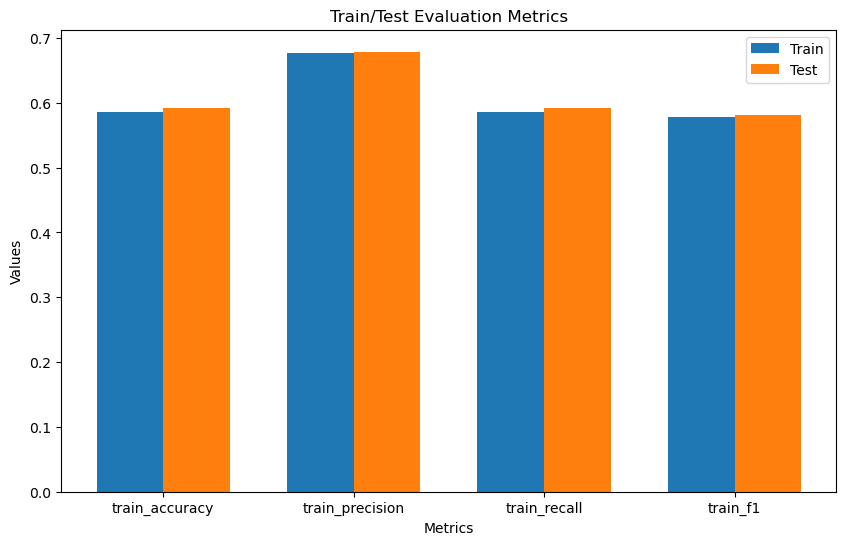

In [238]:
metric_names = list(evaluation_result.keys())
metric_values = list(evaluation_result.values())

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(metric_names) // 2)  # Grouped by pairs
train_metrics = metric_values[:len(metric_values) // 2]
test_metrics = metric_values[len(metric_values) // 2:]

plt.bar(index, train_metrics, bar_width, label='Train')
plt.bar([i + bar_width for i in index], test_metrics, bar_width, label='Test')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Train/Test Evaluation Metrics')
plt.xticks([i + bar_width / 2 for i in index], metric_names[:len(metric_names) // 2])
plt.legend()
plt.show()

#  The most frequent words within each class  as a new feature to improve the model 